# Fish Generator

The goal here is to make a GAN that can produce tropical looking fake fish

## Exploring the data

In [1]:
import os
import sys

import numpy as np  
import pandas as pd 

import sklearn
import tensorflow as tf
from tensorflow import keras

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


import glob
import imageio

import math
import random
import time
import datetime
import shutil
from tqdm import tqdm, tqdm_notebook

from dataclasses import dataclass
from pathlib import Path
import warnings
from scipy import linalg

import xml.etree.ElementTree as ET 

import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from IPython import display
from IPython.display import Image as IpyImage

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Accuracy

from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model

print(os.listdir("./"))


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


['FishGAN.ipynb', 'README.md', 'ImagePrep', '.ipynb_checkpoints', '.git']


In [6]:
#FishDIR='./ProcessedFish/'
FishDIR='../CustomFish/'
GenFishDIR='../FakeFish/'
GIFDIR = "../GIFs/"
h5DIR = '../h5s/'

In [7]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        # note: rounding errors can cause issue here, added a fix to remove them
        
        plt.imshow((image + 1.)/2.0001+0.00001, cmap="binary")
        #plt.imshow(image, cmap="binary")
        plt.axis("off")

def read_image(src):
    img = cv2.imread(src)
    if img is None:
        print(src)
        raise FileNotFoundError
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def write_image(img,filename):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, img)

customOs={'LeakyReLU': LeakyReLU}

def constructGIF(ix,filename):
    gif_path = GIFDIR+filename+".gif"
    frames_path = GIFDIR+filename+"_{i}.jpg"
    with imageio.get_writer(gif_path, mode='I') as writer:
        for i in range(ix):
            writer.append_data(imageio.imread(frames_path.format(i=i)))

#IpyImage(filename=GIFDIR+modelname+"_test.gif")

def plot_history(d1_hist, d2_hist, g_hist):
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    #plt.savefig('./plot_line_plot_loss.png')
    #plt.close()

# Further pre-processing

In [8]:
FishFiles = os.listdir(FishDIR)
# reshape and rescale into a numpy array
Xtrain = np.stack([ read_image(FishDIR+i) * np.float32(2. / 255.) - 1  for i in FishFiles ])

In [9]:
Xtrain[1].dtype

dtype('float32')

In [10]:
# Image processing

datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.05,
        height_shift_range=0.1,
        shear_range=0.05,
        zoom_range=[0.95,1.1],
        brightness_range=[0.8,1.3],
        horizontal_flip=True,
        fill_mode='nearest')

# adjust the saturation of the image
def colorSaturationAdjust(img, satRange=[0.6,1.4]):
    rSat = random.triangular(satRange[0],satRange[1])
    gSat = random.triangular(satRange[0],satRange[1])
    bSat = random.triangular(satRange[0],satRange[1])
    satVar = [rSat, gSat, bSat]
    return np.clip(img * satVar,0,1)

def multiprocessingI(imglist):
    imglistproc = []
    for img in datagen.flow((imglist+1.)/2.000)[0]:
        imglistproc.append(np.clip(2.*(colorSaturationAdjust(img/255.0)-0.5),-1.,1.))
        #imglistproc.append(colorSaturationAdjust(img/255.0))
    return np.asarray(imglistproc)

# Defining Architecture

In [14]:
tf.random.set_seed(7777)
np.random.seed(7777)

codings_size = 100
dropoutVal = 0.5
LReluAlpha = 0.15

# 128 x 128 = 2 * 2 * 2 * 2 * 2 = 8 x 8 

generator = keras.models.Sequential([
    keras.layers.Dense(8 * 8 * 256, input_shape=[codings_size]),
    keras.layers.Reshape([8, 8, 256]),
    keras.layers.BatchNormalization(),
    # image 8x8 -> 16x16
    keras.layers.Conv2DTranspose(256, (5,5), strides=(2,2), padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    # image 16x16 -> 32x32
    keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    # image 32x32 -> 64x64
    keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    # image 64x64 -> 128x128
    keras.layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, (5,5), padding="SAME",
                                 activation="tanh")
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(LReluAlpha),
                        input_shape=[128, 128, 3]),
    keras.layers.Dropout(dropoutVal),
    keras.layers.Conv2D(64, (5,5), strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(LReluAlpha)),
    keras.layers.Dropout(dropoutVal),
    keras.layers.Conv2D(128, (5,5), strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(LReluAlpha)),
    keras.layers.Dropout(dropoutVal),
    keras.layers.Conv2D(256, (5,5), strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(LReluAlpha)),
    keras.layers.Dropout(dropoutVal),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])
modelname = 'gan_RMSp001_128_4x1_4x1'
modelname = 'gan_RMSasym_p00015_p0001_128_4x1_4x1'

In [15]:
optimizergen = RMSprop(learning_rate=0.00015, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
optimizerdisc = RMSprop(learning_rate=0.0001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#optimizergen = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-06, amsgrad=False)
#optimizerdisc = Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=1e-06, amsgrad=False)

In [16]:
discriminator.compile(loss="binary_crossentropy", optimizer=optimizerdisc, metrics=['accuracy'])
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=optimizergen, metrics = ['accuracy'])

In [17]:
#for GIF
batch_size = 32
fixednoise = tf.random.normal(shape=[batch_size, codings_size])
imgsetforGIF = []

dataset = tf.data.Dataset.from_tensor_slices(Xtrain)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# Wasserstein  uses -1 = real and +1 == fake
halfbatch = int(batch_size/2)
#yfake = tf.constant([[1.]] * halfbatch)
#yreal = tf.constant([[-1.]] * batch_size)
yfake = tf.constant([[0.]] * halfbatch)
yreal = tf.constant([[1.]] * batch_size)

d_loss1_hist, d_loss2_hist, g_loss_hist = list(), list(), list()
d_acc1_hist, d_acc2_hist, g_acc_hist = list(), list(), list()

In [18]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50,epoch_offset=0):
    generator, discriminator = gan.layers
    nepochs = epoch_offset + n_epochs
    ncounter = 0
    for epoch in range(epoch_offset,nepochs):
        print("Epoch {}/{}".format(epoch + 1,nepochs))  
        starttime = time.time()
        d_loss1, d_loss2, g_loss, d_acc1, d_acc2, g_acc, xii, gii = 0, 0, 0, 0, 0, 0, 0, 0
        for X_batch in dataset:
            xii+=1
            #ncounter+=1
            # phase 1 - training the discriminator
            discriminator.trainable = True
            
            # Note: this might not be the best decision - but I am splitting 
            #       the batches here to measure real and fake loss separately
            #X_fake_and_real = tf.concat([generated_images, X_batch_proc], axis=0)
            #y1 = tf.constant([[1.]] * batch_size + [[-1.]] * batch_size)
            
            # gen fake
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            # first half fake
            d_loss2_t, d_acc2_t = discriminator.train_on_batch(generated_images[:halfbatch], yfake)
            d_loss2+=d_loss2_t
            d_acc2+=d_acc2_t
            # then real
            #X_batch_proc = X_batch
            X_batch_proc = multiprocessingI(X_batch)
            d_loss1_t, d_acc1_t = discriminator.train_on_batch(X_batch_proc, yreal)
            d_loss1+=d_loss1_t 
            d_acc1+=d_acc1_t
            # then second half fake
            d_loss2_t, d_acc2_t = discriminator.train_on_batch(generated_images[halfbatch:], yfake)
            d_loss2+=d_loss2_t
            d_acc2+=d_acc2_t

            # phase 2 - training the generator (only done 1 in ncritic times)
            #if(ncounter % ncritic == 0):
            #   ncounter = 0
            noise = tf.random.normal(shape=[batch_size, codings_size])
            discriminator.trainable = False
            g_loss_t, g_acc_t = gan.train_on_batch(noise, yreal)
            g_loss+=g_loss_t
            g_acc+=g_acc_t
            gii+=1
                
        if epoch % 3 == 0 or epoch+1 == nepochs: 
            imgsetforGIF.append(generator(fixednoise))
            if epoch > 1:
                plot_multiple_images(generated_images, 8)               
                plt.show()   
        if epoch > 100 and epoch % 20 == 19:
            filename = h5DIR+'/fish_{}_back_ep{}.h5'.format(modelname,epoch+1)
            gan.save(filename)
        d_loss1 /= xii   
        d_loss2 /= xii  
        g_loss /= gii
        d_acc1 /= xii   
        d_acc2 /= (2*xii)  
        g_acc /= gii
        d_loss1_hist.append(d_loss1)
        d_loss2_hist.append(d_loss2)
        g_loss_hist.append(g_loss)
        d_acc1_hist.append(d_acc1)
        d_acc2_hist.append(d_acc2)
        g_acc_hist.append(g_acc)
        print('Epoch took {time:.3f} seconds: d_loss_real={dl1:.3f}, d_loss_fake={dl2:.3f}, g_loss={gl:.3f}'.format(time=time.time() - starttime, dl1 = d_loss1, dl2 = d_loss2, gl = g_loss))
        print('                             : d_acc_real={dl1:.0%}, d_acc_fake={dl2:.0%}, g_acc={gl:.0%}'.format(dl1 = d_acc1, dl2 = d_acc2, gl = g_acc))

In [ ]:
train_gan(gan, dataset, batch_size, codings_size,n_epochs = 300,epoch_offset=0)

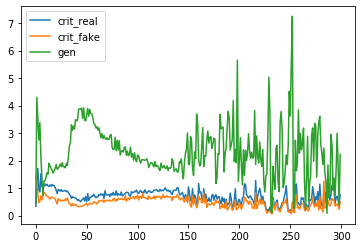

In [20]:
plot_history(d_loss1_hist,d_loss2_hist,g_loss_hist)
plt.show()

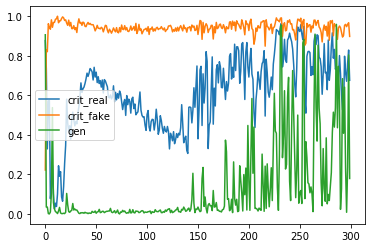

In [21]:
plot_history(d_acc1_hist,d_acc2_hist,g_acc_hist)
plt.show()

In [ ]:
frames_path = GIFDIR+modelname+"_{i}.jpg"
for i, imgs in enumerate(imgsetforGIF):
    plot_multiple_images(imgs, 8)
    plt.savefig(frames_path.format(i=i))
    plt.close()
constructGIF(len(imgsetforGIF),modelname)
#IpyImage(filename=GIFDIR+modelname+".gif")

In [ ]:
#IpyImage(filename=GIFDIR+modelname+".gif")

In [ ]:
filename = h5DIR+'/fish_'+modelname+'.h5'
gan.save(filename)

In [22]:
#save gan to files
filename = './h5s/fish_gan_1.h5'
gan.save(filename)

In [ ]:
frames_path = GIFDIR+"gan1_{i}.jpg"
for i, imgs in enumerate(imgsetforGIF):
    plot_multiple_images(imgs, 8)
    plt.savefig(frames_path.format(i=i))
    plt.close()
constructGIF(len(imgsetforGIF),"gan1")
#IpyImage(filename=GIFDIR+"gan1.gif")

In [25]:
#IpyImage(filename=GIFDIR+"gan1.gif")

In [12]:
# load model
gan = load_model('./h5s/fish_gan_1.h5',custom_objects=customOs)
generator, discriminator = gan.layers

codings_size = 100
batch_size = 32

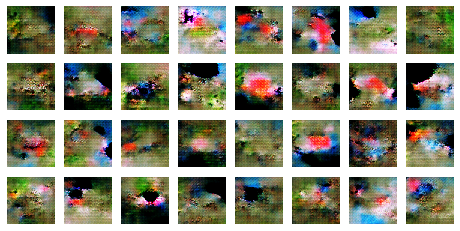

In [15]:
noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)

# Check proximity

In [ ]:
def imageDistance(im1,im2):
    dist = 0
    if len(im1) != len(im2) or len(im1[0]) != len(im2[0]) or len(im1[0][0]) != len(im2[0][0]):
        print("Images are not the same size")
        return 255. * len(im1) * len(im1[0])* len(im1[0][0])
    imx = im1 - im2
    return float(tf.math.reduce_sum(imx*imx))**0.5

def findClosestImage(genimg,imgset):
    distSet = False
    bestdist = 10**20
    for img in imgset:
        curdist = imageDistance(genimg, img)
        if curdist < bestdist or not distSet:
            bestdist = curdist
            bestimg = img
            distSet = True
    return bestimg

In [ ]:
plot_multiple_images(generated_images, 8)

In [ ]:
imID = 1
plt.imshow((generated_images[imID]+1)/2)                
plt.show()

In [ ]:
closestim = findClosestImage(generated_images[imID],Xtrain)
plt.imshow((closestim+1)/2)                
plt.show()